# DATA 604 HW2

Magnus Skonberg | June 14th 2021

These exercises and their solutions were made with reference to *Modeling and Simulation in Python* (version 3) authored by Allen B. Downey. This week's exercises focused on **Growth Models**, chapters 6 and 7 of the text.

In [1]:
# Initialize Jupyter: figures appear in notebook, values displayed after assignment

%matplotlib inline
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# Initialize libraries

from modsim import * # import functions from the modsim library
from pandas import read_html

## Chapter 6 Exercises

### Code from previous chapter

In [2]:
filename = 'data/World_population_estimates.html'
tables = read_html(filename, header=0, index_col=0, decimal='M')
table2 = tables[2]
table2.columns = ['census', 'prb', 'un', 'maddison', 
                  'hyde', 'tanton', 'biraben', 'mj', 
                  'thomlinson', 'durand', 'clark']

un = table2.un / 1e9
un.head()

census = table2.census / 1e9
census.head()

Year
1950    2.557629
1951    2.594940
1952    2.636772
1953    2.682053
1954    2.730228
Name: census, dtype: float64

### System objects

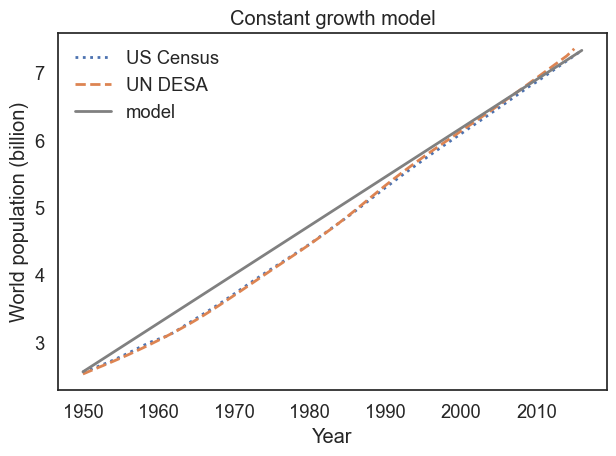

In [3]:
#Calculate elapsed time (years)
t_0 = get_first_label(census)
t_end = get_last_label(census)
elapsed_time = t_end - t_0

#Calculate total growth (population in billions)
p_0 = get_first_value(census)
p_end = get_last_value(census)
total_growth = p_end - p_0

#Calculate annual population growth rate
annual_growth = total_growth / elapsed_time

#Rewrite code from previous chapter using system objects
system = System(t_0=t_0, 
                t_end=t_end,
                p_0=p_0,
                annual_growth=annual_growth)

#Encapsulate model running function
def run_simulation1(system):
    """Runs the constant growth model.
    
    system: System object
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in linrange(system.t_0, system.t_end):
        results[t+1] = results[t] + system.annual_growth
    
    return results

#Encapsulate plotting
def plot_results(census, un, timeseries, title):
    """Plot the estimates and the model.
    
    census: TimeSeries of population estimates
    un: TimeSeries of population estimates
    timeseries: TimeSeries of simulation results
    title: string
    """
    plot(census, ':', label='US Census')
    plot(un, '--', label='UN DESA')
    plot(timeseries, color='gray', label='model')
    
    decorate(xlabel='Year', 
             ylabel='World population (billion)',
             title=title)
    
#Run it
results = run_simulation1(system)
plot_results(census, un, results, 'Constant growth model')

### Population growth

Here's a more realistic model where the number of births and deaths is proportional to the current population.

Saving figure to file figs/chap06-fig01.pdf


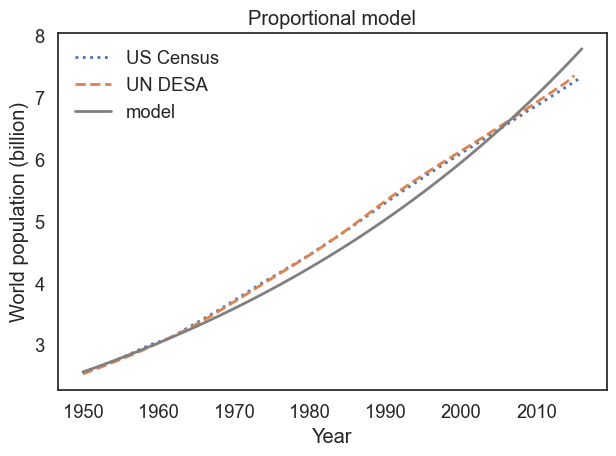

In [4]:
def run_simulation2(system):
    """Run a model with proportional birth and death.
    
    system: System object
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in linrange(system.t_0, system.t_end):
        births = system.birth_rate * results[t]
        deaths = system.death_rate * results[t]
        results[t+1] = results[t] + births - deaths
        
    return results

#Set system birth and death rates (within reason)
system.death_rate = 0.01
system.birth_rate = 0.027

#Run simulation and plot
results = run_simulation2(system)
plot_results(census, un, results, 'Proportional model')
savefig('figs/chap06-fig01.pdf')

The model fits the data pretty well for the first 20 years, but not so well after that.

### Factoring out update function

`run_simulation1` and `run_simulation2` are nearly identical except the body of the loop.  So we can factor that part out into a function.

In [5]:
def update_func1(pop, t, system):
    """Compute the population next year.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
    births = system.birth_rate * pop
    deaths = system.death_rate * pop
    return pop + births - deaths

#Verify function object
update_func1
type(update_func1)

def run_simulation(system, update_func):
    """Simulate the system using any update function.
    
    system: System object
    update_func: function that computes the population next year
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in linrange(system.t_0, system.t_end):
        results[t+1] = update_func(results[t], t, system)
        
    return results

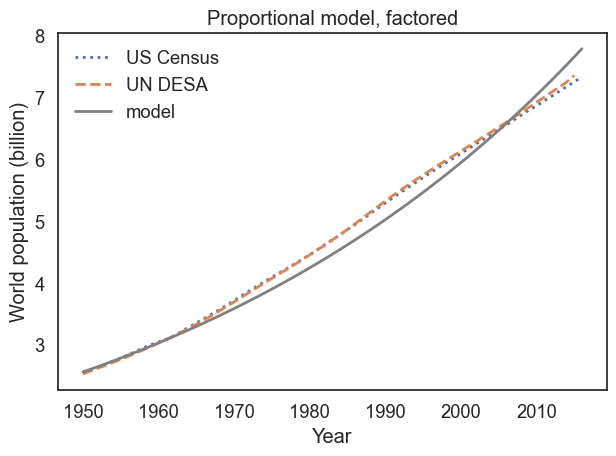

In [6]:
t_0 = get_first_label(census)
t_end = get_last_label(census)
p_0 = census[t_0]

system = System(t_0=t_0, 
                t_end=t_end,
                p_0=p_0,
                birth_rate=0.027,
                death_rate=0.01)

results = run_simulation(system, update_func1)
plot_results(census, un, results, 'Proportional model, factored')

Remember not to put parentheses after update_func1. What happens if you try?

### Excercise

When you run `run_simulation`, it runs `update_func1` once for each year between `t_0` and `t_end`.  To see that for yourself, add a print statement at the beginning of `update_func1` that prints the values of `t` and `pop`, then run `run_simulation` again.

In [7]:
def update_func1(pop, t, system):
    """Compute the population next year.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
    print("t:",t,"pop:",pop)
    births = system.birth_rate * pop
    deaths = system.death_rate * pop
    return pop + births - deaths

results = run_simulation(system, update_func1)

t: 1950 pop: 2.557628654
t: 1951 pop: 2.601108341118
t: 1952 pop: 2.645327182917006
t: 1953 pop: 2.6902977450265952
t: 1954 pop: 2.7360328066920476
t: 1955 pop: 2.7825453644058125
t: 1956 pop: 2.829848635600711
t: 1957 pop: 2.8779560624059233
t: 1958 pop: 2.926881315466824
t: 1959 pop: 2.9766382978297603
t: 1960 pop: 3.0272411488928666
t: 1961 pop: 3.078704248424045
t: 1962 pop: 3.131042220647254
t: 1963 pop: 3.184269938398258
t: 1964 pop: 3.2384025273510284
t: 1965 pop: 3.293455370315996
t: 1966 pop: 3.349444111611368
t: 1967 pop: 3.406384661508761
t: 1968 pop: 3.46429320075441
t: 1969 pop: 3.523186185167235
t: 1970 pop: 3.583080350315078
t: 1971 pop: 3.6439927162704344
t: 1972 pop: 3.7059405924470314
t: 1973 pop: 3.768941582518631
t: 1974 pop: 3.833013589421448
t: 1975 pop: 3.8981748204416125
t: 1976 pop: 3.9644437923891203
t: 1977 pop: 4.031839336859735
t: 1978 pop: 4.100380605586351
t: 1979 pop: 4.170087075881319
t: 1980 pop: 4.240978556171301
t: 1981 pop: 4.313075191626214
t: 1982

,values
1950,2.557629
1951,2.601108
1952,2.645327
1953,2.690298
1954,2.736033
...,...
2012,7.273385
2013,7.397032
2014,7.522782
2015,7.650669


### Combining birth and death

Since births and deaths get added up, we don't have to compute them separately.  We can combine the birth and death rates into a single net growth rate.

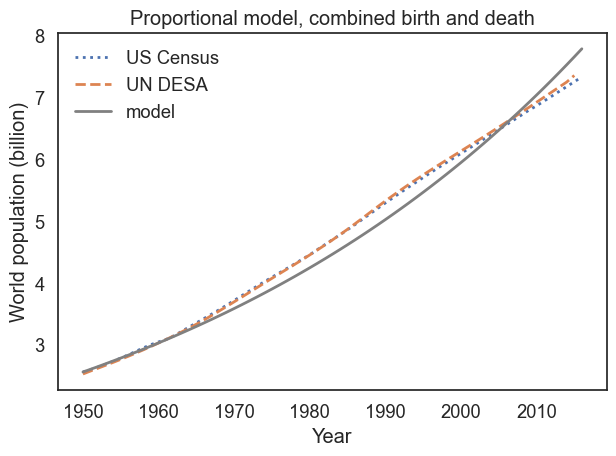

In [8]:
def update_func2(pop, t, system):
    """Compute the population next year.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
    net_growth = system.alpha  * pop
    return pop + net_growth

system.alpha = system.birth_rate - system.death_rate

results = run_simulation(system, update_func2)
plot_results(census, un, results, 'Proportional model, combined birth and death')

### Exercises

Maybe the reason the proportional model doesn't work very well is that the growth rate, `alpha`, is changing over time.  So let's try a model with different growth rates before and after 1980 (as an arbitrary choice).

Write an update function that takes `pop`, `t`, and `system` as parameters.  The system object, `system`, should contain two parameters: the growth rate before 1980, `alpha1`, and the growth rate after 1980, `alpha2`.  It should use `t` to determine which growth rate to use.  Note: Don't forget the `return` statement.

Test your function by calling it directly, then pass it to `run_simulation`.  Plot the results.  Adjust the parameters `alpha1` and `alpha2` to fit the data as well as you can.


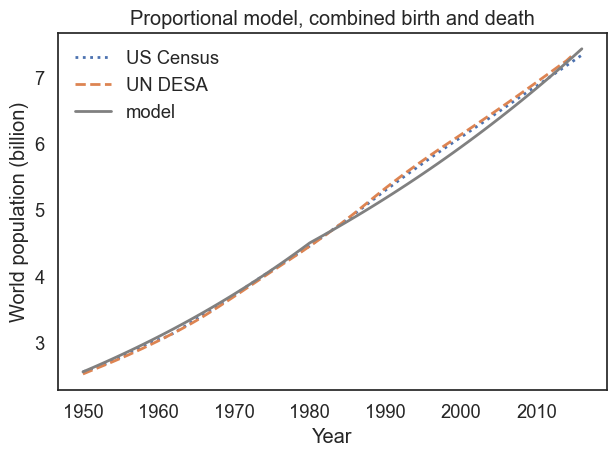

In [9]:
#Write an update function that takes pop, t, and system as parameters
def update_func3(pop, t, system):
    """Compute the population next year.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
    if t < 1980:
        net_growth = system.alpha1  * pop
    elif t >= 1980:
        net_growth = system.alpha2  * pop
    
    return pop + net_growth

#Growth rates before/after 1980
system.alpha1 = 0.019 
system.alpha2 = 0.014

results = run_simulation(system, update_func3)
plot_results(census, un, results, 'Proportional model, combined birth and death')

I assumed that the birth-to-death ratio was higher pre-1980 and lower post-1980. After playing with the alpha values, we see that our model fits the data quite well pre-1980 and strays a bit from ~1990-2010 for post-1980 data. It appears that breaking our alpha value down further (ie. per decade) may increase the precision of our model even more.

## Chapter 7 Exercises

### Quadratic Growth

Here's the implementation of the quadratic growth model.

Saving figure to file figs/chap07-fig01.pdf


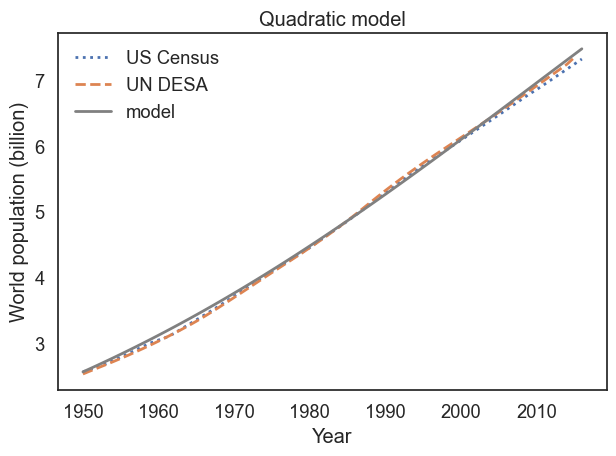

In [10]:
def update_func_quad(pop, t, system):
    """Compute the population next year with a quadratic model.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
    net_growth = system.alpha * pop + system.beta * pop**2
    return pop + net_growth

#Here's a `System` object with the parameters `alpha` and `beta`:

t_0 = get_first_label(census)
t_end = get_last_label(census)
p_0 = census[t_0]

system = System(t_0=t_0, 
                t_end=t_end,
                p_0=p_0,
                alpha=0.025,
                beta=-0.0018)

results = run_simulation(system, update_func_quad)
plot_results(census, un, results, 'Quadratic model')
savefig('figs/chap07-fig01.pdf')

### Exercise 

Can you find values for the parameters that make the model fit better?


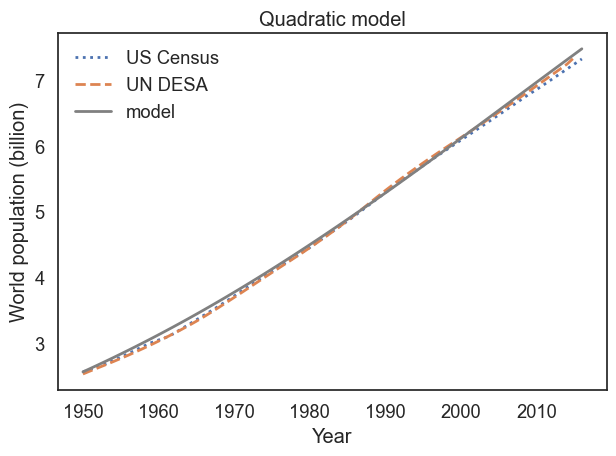

In [33]:
#Use least squares method to find optimal alpha, beta values (best fit)

system = System(t_0=t_0, 
                t_end=t_end,
                p_0=p_0,
                alpha=0.0255,
                beta=-0.0019)

results = run_simulation(system, update_func_quad)
plot_results(census, un, results, 'Quadratic model')

I varied `alpha` and `beta` values quite a bit and found that those above appear to provide a closer fit. Manual trial&error is faulted though and an "automated" algorithm would be preferred for optimizing the fit.

### Equilibrium

Saving figure to file figs/chap07-fig02.pdf


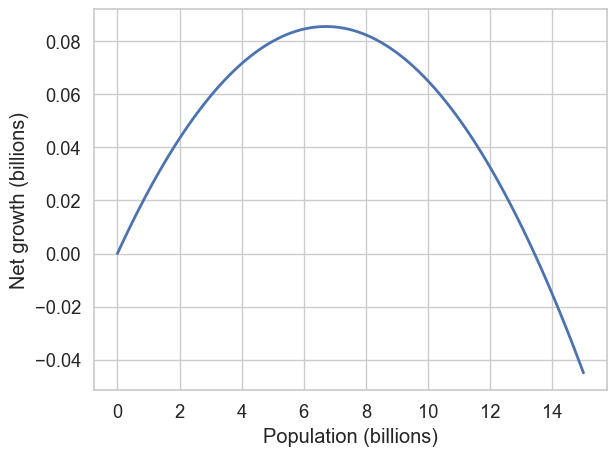

In [27]:
pop_array = linspace(0, 15, 100)
net_growth_array = system.alpha * pop_array + system.beta * pop_array**2
None

sns.set_style('whitegrid')

plot(pop_array, net_growth_array)
decorate(xlabel='Population (billions)',
         ylabel='Net growth (billions)')

sns.set_style('white')

savefig('figs/chap07-fig02.pdf')

It looks like the growth rate passes through 0 when the population is a little less than 14 billion. In the book we found that the net growth is 0 when the population is $-\alpha/\beta$:

In [30]:
#1st set
system.alpha = 0.025
system.beta = 0.0018
-system.alpha / system.beta #-13.889

#2nd set
system.alpha = 0.0255
system.beta = 0.0019
-system.alpha / system.beta #-13.421


-13.421052631578947

### Dysfunctions


In [31]:
def carrying_capacity(system):
    K = -system.alpha / system.beta
    return K
    
sys1 = System(alpha=0.025, beta=-0.0018)
pop = carrying_capacity(sys1)
print(pop)

13.88888888888889


## Exercises

**Exercise:** In the book, I present a different way to parameterize the quadratic model:

$ \Delta p = r p (1 - p / K) $

where $r=\alpha$ and $K=-\alpha/\beta$.  Write a version of `update_func` that implements this version of the model.  Test it by computing the values of `r` and `K` that correspond to `alpha=0.025, beta=-0.0018`, and confirm that you get the same results. 

In [36]:
# Solution goes here
def update_func_v(r, K, p):
    """Compute the population next year with a quadratic model.
    system: system object containing parameters of the model
    returns: population next year
    """
    
    #compute delta p
    growth = (r * p) * (1 - (p / K))
    
    return p + growth

#Initialize variables
K = -system.alpha / system.beta
p = system.p_0
r = system.alpha

#Test
print(update_func_v(r, K, p))

#Compare
census.head()


2.6104194024466527


Year
1950    2.557629
1951    2.594940
1952    2.636772
1953    2.682053
1954    2.730228
Name: census, dtype: float64

From above we see that our `update_func_v` value and census values for 1951 are quite close and thus it appears that the provided equation is accurate (at least) for the 1st value.